# Propensity Modeling

In [1]:
import numpy as np
import pandas as pd
import pickle
# import urllib
# from tqdm import tqdm, trange, tqdm_pandas
# import os
# from user_agents import parse
# import datetime
from time import time
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import cycle
# pd.set_option('display.max_columns', 1000)

##  1. Data

In [2]:
%%time
with open("../Data/Feature_Engineering/df_features_normalize.p", "rb" ) as f:
    data_features = pickle.load(f)    
with open( "../Data/Feature_Engineering/df_label.p", "rb" ) as f:
    data_label = pickle.load(f)

CPU times: user 635 ms, sys: 3.83 s, total: 4.47 s
Wall time: 4.47 s


In [3]:
%%time
X = data_features
Y = data_label
print(X.shape)

(220047, 2357)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 303 µs


### 1.1 Split data to training set, validation set and test set

In [4]:
print(X.shape)
bar_80 = np.floor(X.shape[0]*0.8).astype(int)
bar_80=bar_80+1
bar_80

(220047, 2357)


176038

In [5]:
X_train=X[:bar_80]
Y_train=Y[:bar_80]
X_test=X[bar_80:]
Y_test=Y[bar_80:]

## 2.0 Feature Selection

In [11]:
%%time
clf=RandomForestClassifier(n_estimators=100,criterion='gini',max_features= 10, 
                           min_samples_leaf=3, bootstrap= False, max_depth= 25, 
                           min_samples_split= 15)

clf.fit(X_train, Y_train)

clf.feature_importances_ 
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(220047, 64)
CPU times: user 27.6 s, sys: 857 ms, total: 28.5 s
Wall time: 28.6 s


In [12]:
X_train=X_new[:bar_80]
Y_train=Y[:bar_80]
X_test=X_new[bar_80:]
Y_test=Y[bar_80:]
print(X_train.shape)

(176038, 64)


## 2. GradientBoosting Classifier


|  Parameters  |  Explanation |  
|---|---|---|---|---|
|  n_estimators | The number of trees in the forest  |   
| criterion  | The function to measure the quality of a split.  |   
|  max_depth | The number of features to consider when looking for the best split  |   
|  max_depth | The maximum depth of the tree.  |   
|  min_samples_split |   |  
| min_samples_leaf  |   |  
| max_features  |   |  
| max_leaf_nodes  |   |   
| bootstrap  |   |   
| oob_score  |   |   
|  n_jobs |   |   
|  random_state |   |   
|  verbose |   |  
|  warm_start |   |   
|  class_weight |   |   




### 2.1 Random Search

In [17]:
# Report function
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
clf = GradientBoostingClassifier()

param_dist = {"learning_rate":[0.1,0.5,1,2,3,5,10],
             "n_estimators": [100,300,500,1000],
             "max_depth": [3,8,10,15,20],
#               "criterion":
              "min_samples_split":[2,100,300,500],
              "min_samples_leaf":[1,10,20,50],
#               "min_weight_fraction_leaf":
#               "subsample":[0.8,1,]
              "max_features":['sqrt'],
#               "max_leaf_nodes":
#               "min_impurity_split":
#               "min_impurity_decrease"
             }

n_iter_search = 50
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_train, Y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)
# 5, 500 is not the optimal one. 1, 1000 is far more better.

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/gradient_boosting.py:517: RuntimeWarning: overflow encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/gradient_boosting.py:490: RuntimeWarning: invalid value encountered in multiply
  np.sum(sample_weight * ((y * pred) - np.logaddexp(0.0, pred))))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/gradient_boosting.py:490: RuntimeWarning: invalid value encountered in subtract
  np.sum(sample_weight * ((y * pred) - np.logaddexp(0.0, pred))))


In [5]:
Y_pred=random_search.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))
print('---------------------------------------------------------------------------------------------------------')
report(random_search.cv_results_)

NameError: name 'random_search' is not defined

---
### 2.2 Model Training

In [6]:
%%time
# 1st Parameter combination:
clf=GradientBoostingClassifier(learning_rate=0.1, n_estimators=300,max_depth=10,min_samples_split=100,
                               min_samples_leaf=50, max_features='sqrt')
clf.fit(X_train, Y_train)

CPU times: user 6min 8s, sys: 3.57 s, total: 6min 11s
Wall time: 6min 13s


In [10]:
%%time
# tmp
Y_pred = clf.predict(X_test)
# clf=GradientBoostingClassifier(learning_rate=0.1, n_estimators=300,max_depth=10,min_samples_split=100,
#                                min_samples_leaf=50, max_features='sqrt')

print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.935604080983
CPU times: user 4.33 s, sys: 216 ms, total: 4.55 s
Wall time: 4.57 s


---

In [19]:
%%time
Y_pred = clf.predict(X_test)
# clf=GradientBoostingClassifier(learning_rate=0.1, n_estimators=300,max_depth=10,min_samples_split=100,
#                                min_samples_leaf=50, max_features='sqrt')

print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.939944102343
CPU times: user 771 ms, sys: 3 ms, total: 774 ms
Wall time: 821 ms


In [22]:
%%time
# 3nd Parameter combination:
clf=GradientBoostingClassifier(learning_rate=0.1, n_estimators=300,max_depth=15,min_samples_split=100,
                               min_samples_leaf=50, max_features='sqrt')
# clf=GradientBoostingClassifier(learning_rate=0.2, n_estimators=300,max_depth=15,min_samples_split=500,
#                                min_samples_leaf=50, max_features='sqrt')
#0.937467336227
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.938967029471
CPU times: user 8min 45s, sys: 205 ms, total: 8min 45s
Wall time: 8min 45s


In [21]:
%%time
# 2nd Parameter combination:
clf=GradientBoostingClassifier(learning_rate=0.2, n_estimators=300,max_depth=15,min_samples_split=100,
                               min_samples_leaf=50, max_features='sqrt')
# clf=GradientBoostingClassifier(learning_rate=0.2, n_estimators=300,max_depth=15,min_samples_split=500,
#                                min_samples_leaf=50, max_features='sqrt')
#0.937467336227
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.936717489604
CPU times: user 8min 59s, sys: 1.14 s, total: 9min
Wall time: 9min


---

In [13]:
%%time
clf=GradientBoostingClassifier()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52 µs


In [14]:
%%time
clf.fit(X_train, Y_train)

CPU times: user 48.7 s, sys: 362 ms, total: 49.1 s
Wall time: 49.1 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

### 2.1 Save Model

In [9]:
%%time
path = '../Data/Propensity_Modeling/GradientBoosting.pkl'
joblib.dump(clf, path)

# clf=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
#                            min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
#                            oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
#                            class_weight=None)

CPU times: user 10 ms, sys: 8 ms, total: 18 ms
Wall time: 880 ms


In [32]:
Y_predict=clf.predict(X_test)

### 2.2 Load Model

In [10]:
%%time
# load the model from disk
path = '../Data/Propensity_Modeling/GradientBoosting.pkl'
clf = joblib.load(path)

# result = loaded_model.score(X_test, Y_test)
# print(result)

CPU times: user 130 ms, sys: 437 ms, total: 567 ms
Wall time: 567 ms


## 3. Result Analysis

### 3.1 Accuracy Rate

In [15]:
%%time
Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.933445431616
CPU times: user 165 ms, sys: 3 ms, total: 168 ms
Wall time: 182 ms


In [11]:
# Result with 100 trees
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96     37065
          1       0.84      0.72      0.77      6944

avg / total       0.93      0.93      0.93     44009



In [12]:
1-sum(Y_test)/len(Y_test)

0.84221409257197388

### 3.2 Confusion matrix

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix is:
 [[36119   946]
 [ 1959  4985]]

Plot of Confusion Matrix is:


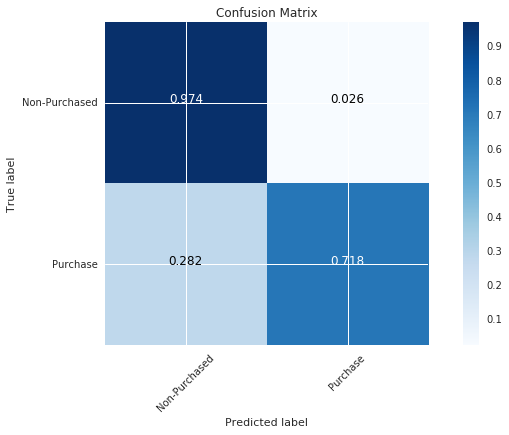

In [14]:
Y_pred = clf.predict(X_test)
# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test, Y_pred))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)

**feature Importance check**

In [15]:
clf.feature_importances_

array([ 0.03149002,  0.00453709,  0.01628311, ...,  0.00427691,
        0.        ,  0.        ])

### 3.3 ROC 

In [11]:
n_classes=1
Y_prob = clf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, Y_prob[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_prob[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

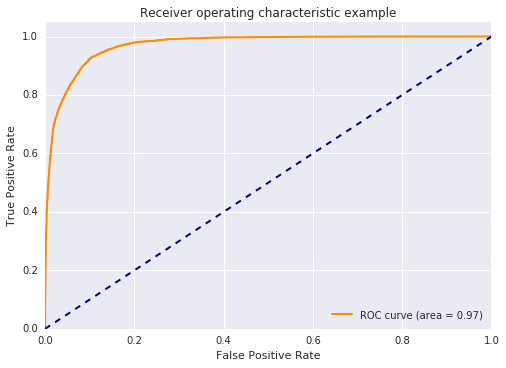

In [12]:
# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


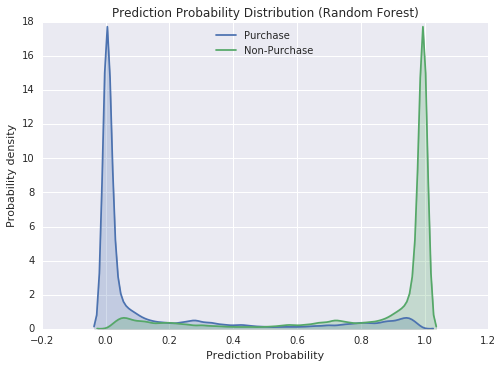

In [13]:
import seaborn as sns
sns.set(color_codes=True)

Y_prob = clf.predict_proba(X_test)

sns.kdeplot(Y_prob[:,1], shade=True, label="Purchase");
sns.kdeplot(Y_prob[:,0], shade=True, label="Non-Purchase");

# sns.kdeplot(Y_prob[:,1], shade=True,cut=0, label="Purchase");
# sns.kdeplot(Y_prob[:,0], shade=True,cut=0,label="Non-Purchase");

plt.xlabel('Prediction Probability')
plt.ylabel('Probability density')
plt.title(r'Prediction Probability Distribution (Random Forest)')

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


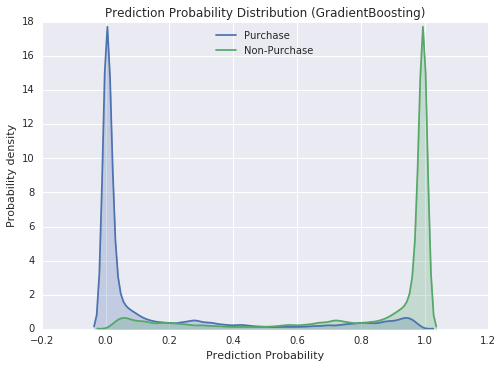

In [15]:
import seaborn as sns
sns.set(color_codes=True)

Y_prob = clf.predict_proba(X_test)

sns.kdeplot(Y_prob[:,1], shade=True, label="Purchase");
sns.kdeplot(Y_prob[:,0], shade=True, label="Non-Purchase");

# sns.kdeplot(Y_prob[:,1], shade=True,cut=0, label="Purchase");
# sns.kdeplot(Y_prob[:,0], shade=True,cut=0,label="Non-Purchase");

plt.xlabel('Prediction Probability')
plt.ylabel('Probability density')
plt.title(r'Prediction Probability Distribution (GradientBoosting)')

---